In [1]:
import pandas as pd
import os
import random
import gensim.models.doc2vec
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
from gensim.models.doc2vec import Doc2Vec
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import networkx as nx
from random import randint 
from itertools import count
import networkx as nx

C:\Users\hongx\AppData\Local\Programs\Python\Python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
Black_keywords = ['man', 'woman', 'men', 'women', 'male', 'female', 'person', 'people', 'community', 'neighborhood', 'child', 'children', 'kid', 'youth', 'business', 'company']

Black_ethnicities = ['black', 'cape verdean', 'afro latino', 'afro latina', 'haitian', 'african american', 'african-american', 'caribbean', 'jamaican', 'dominican', 'west indian']

#pick words from Black_keywords and Black_ethnicities
keywords = ['man', 'woman', 'men', 'women', 'male', 'female', 'person', 'people', 'community', 
            'neighborhood', 'child', 'children','kid', 'youth', 'business', 'company', 'black', 
            'haitian', 'caribbean', 'jamaican', 'dominican']


In [3]:
#bostonglobe2014-----------------------
#remove special characters from bostonglobe flie
spec_chars = ["!",'"',"#","%","&","'","(",")",
            "*","+",",","-",".","/",":",";","<",
            "=",">","?","@","[","\\","]","^","_",
            "`","{","|","}","~","–", "\xc2", "\xa0",
            "\x80", "\x9c", "\x99", "\x94", "\xad", "\xe2", "\x9d"]

df_14 = pd.read_csv('./data-source/bostonglobe2014.csv')
for char in spec_chars:
    df_14['text'] = df_14['text'].str.replace(char, ' ')


<ipython-input-3-6316c0d3cf2f>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_14['text'] = df_14['text'].str.replace(char, ' ')


In [4]:
# setting up doc2vec model
# tokenize the data and clean it using the simple_preprocess method
def tokenize(text, stopwords, max_len = 20):
    return [token for token in gensim.utils.simple_preprocess(text, max_len=max_len) if token not in stopwords]

# convert the tokenized data into one big list of tokens, as opposed to a list of tokenized articles
def target_doc (df):
    articles = df.values.tolist()
    articles_flat = [item for sublist in articles for item in sublist]
    tagged_docs = [gensim.models.doc2vec.TaggedDocument(tokenize(text, [], max_len=200), [i]) for i, text in enumerate(articles_flat)]
    return tagged_docs
    
# create the Doc2Vec model, build the model vocabulary, and train the model on the data
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, epochs=40, window=2, dm=1)
model.build_vocab(target_doc (df_14))
model.train(target_doc (df_14), total_examples=model.corpus_count, epochs=model.epochs)
vector = model.infer_vector(keywords)

In [5]:
#finding similar words and creating a csv file

def compute_similar_words(model,source_word, topn=5):
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words    

def compute_similar_words_for_all_tasks(model,topn=5):
    columns = ['word'+str(i-1) for i in range(1,topn+2)]
    df = pd.DataFrame(data=None,columns=columns)
    for source_word in keywords:
        similar_words = compute_similar_words(model,source_word,topn)
        df.loc[len(df)] = similar_words
    for i in range(1,len(similar_words)):
        sec_similar_words = compute_similar_words(model,similar_words[i],topn)
        df.loc[len(df)] = sec_similar_words
    df.to_csv('./similar_words_task/similar_words_task_2014.csv')
    # df.to_csv('./similar_words_task/similar_words_task_2015.csv')
    # df.to_csv('./similar_words_task/similar_words_task_2016.csv')
    # df.to_csv('./similar_words_task/similar_words_task_2017.csv')
    # df.to_csv('./similar_words_task/similar_words_task_2018.csv')

words = compute_similar_words_for_all_tasks(model)

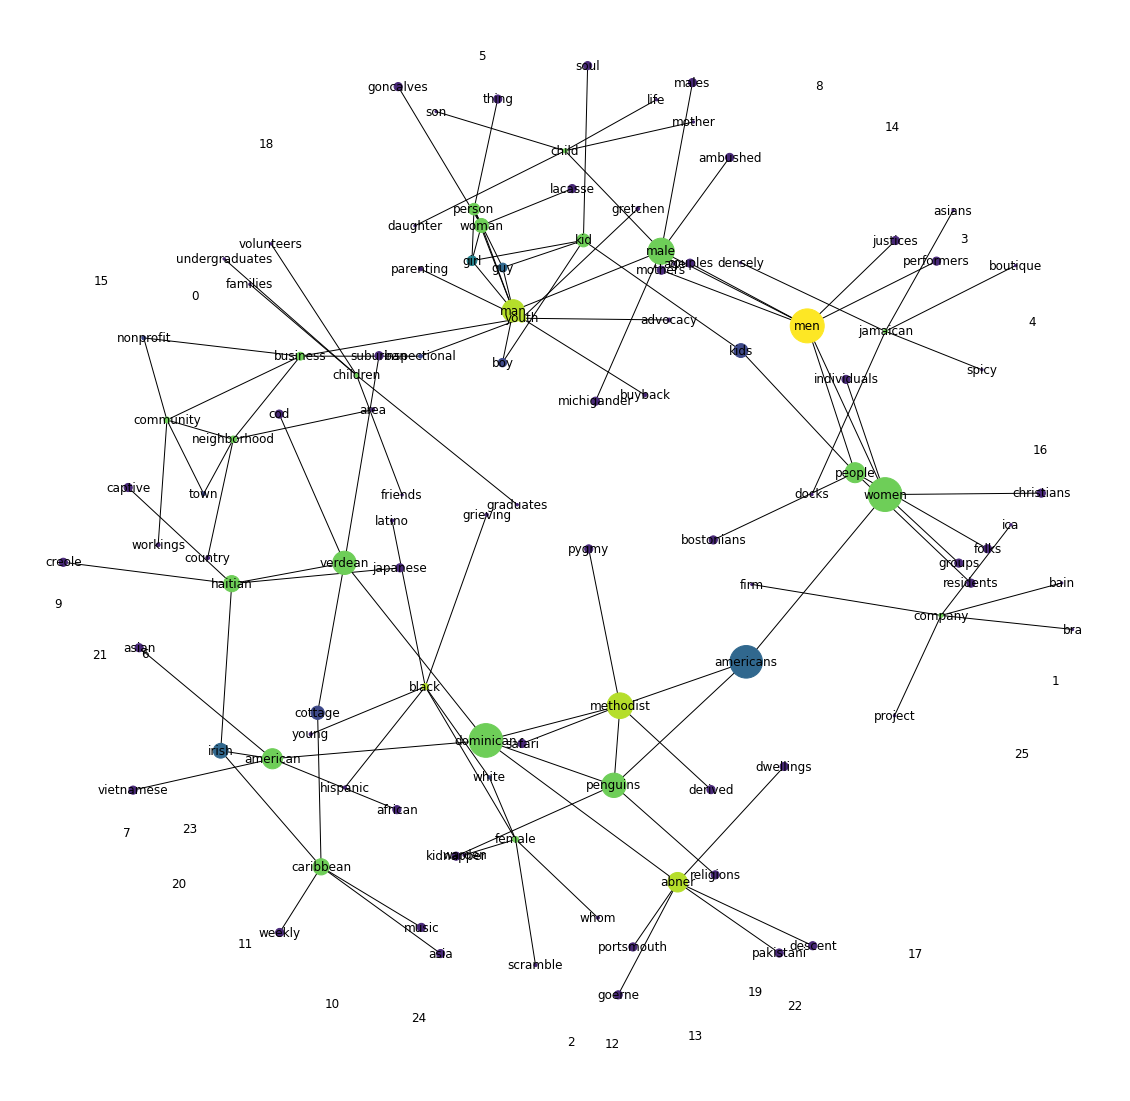

In [6]:
#read in similar words csv file to create WordClouds

words = pd.read_csv('./similar_words_task/similar_words_task_2014.csv')

# words = pd.read_csv('./similar_words_task/similar_words_task_2015.csv')
# words = pd.read_csv('./similar_words_task/similar_words_task_2016.csv')
# words = pd.read_csv('./similar_words_task/similar_words_task_2017.csv')
# words = pd.read_csv('./similar_words_task/similar_words_task_2018.csv')

G = nx.Graph()
j = 1
for i, row in words.iterrows():
    for j in range(1,len(row)):
        G.add_node(i,label=row[j])
    for j in range(1,len(row)):
        G.add_edge(row[1], row[j])
remove = [node for node,degree in dict(G.degree()).items() if degree > 2]
# print(remove)
pos = nx.spring_layout(G,k=0.3)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')
plt.savefig("../img/network_graph_2014.png")
plt.show()